# Forecasting of the "machine learning" searched on googled per month using a dummy model

## Imports

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from pmdarima.arima import StepwiseContext
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Data Loading

In [3]:
df = pd.read_csv('data/playstation_trend.csv', header=1)

In [4]:
df.columns = ['date', 'playstation']
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

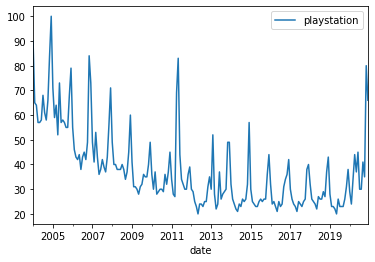

In [5]:
df.plot();

As we can see, we have a strong trend, but also a strong seasonality.

In [6]:
df.playstation.describe()

count    204.000000
mean      37.882353
std       15.691480
min       20.000000
25%       26.000000
50%       33.000000
75%       44.000000
max      100.000000
Name: playstation, dtype: float64

Above, we can see various information on our variable : the median value is 33 and the mean about 38.

So, when looking at the error rate, we can put it in perspective of the actual value given above.

### Autocorrelation

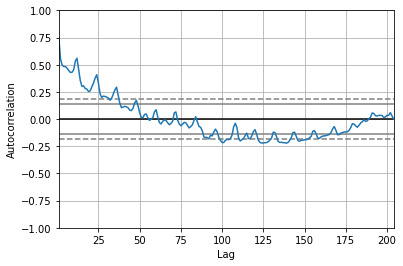

In [7]:
pd.plotting.autocorrelation_plot(df.playstation);

As we can see on the figure above, the previous values have a strong autocorelation with the current values.

Also, there is a strong recuring correlation, meaning the seasonality is important.

### Visualisation

In [8]:
decomposition = seasonal_decompose(df.playstation);

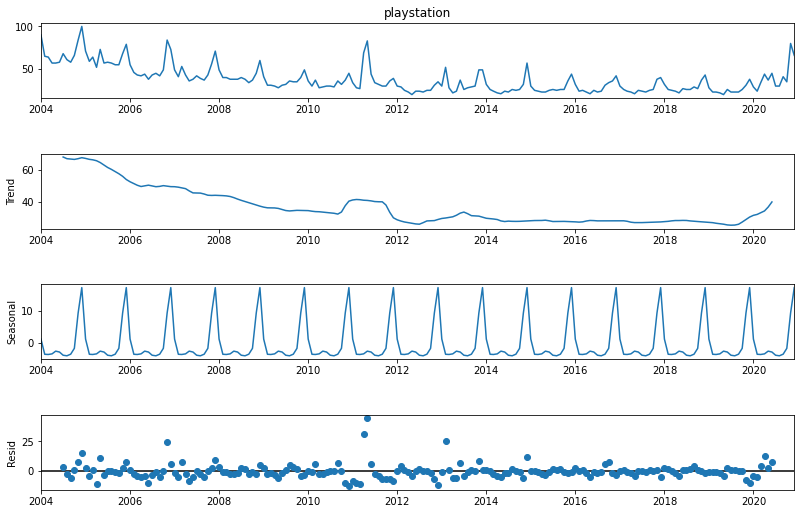

In [9]:
fig = decomposition.plot()
fig.set_size_inches(12, 8);

On the figure above, we have decomposed our data in three variables : trend, seasonality and resids.

They if they are combined, we get the original data :  
`ml = trend + seasonal + resid`

As we can see, the trend values range is more important than the other two, but they are nonetheless substantial.

### Dummy model

Like for the "foie gras", we're going to make a naive model using the data from 12 months ago as a prediction.

In [10]:
df_dummy = df.copy()
df_dummy['naive_prediction'] = df_dummy['playstation'].shift(12)
df_dummy.dropna(inplace=True)

In [11]:
size = int(len(df_dummy) * 0.66)
train, test = df_dummy[0:size], df_dummy[size:len(df_dummy)]

In [12]:
mse = mean_squared_error(test.playstation, test.naive_prediction)
mae = mean_absolute_error(test.playstation, test.naive_prediction)
r2 = r2_score(test.playstation, test.naive_prediction)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 84.51515151515152
	-> mae 4.848484848484849
	-> r2 0.1662729947075089


As we can see this naive prediction is **pretty good**this time, the MAE is about 4.8, and we know that the median value is 33, so it is pretty good.

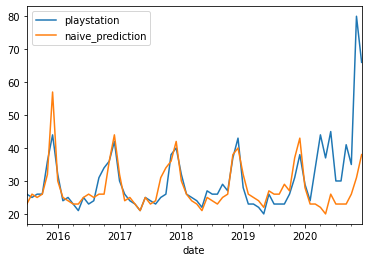

In [13]:
test[['playstation', 'naive_prediction']].plot()
plt.show()

On the figure above, we can see that our prediction works well between 2016 and 2019, but starting 2020, the model doesn't follow accurately what is happening. It reacts too slowly.

### ARIMA Model

In [14]:
model = auto_arima(train.playstation, seasonal=False)
model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
predictions = model.predict(len(test))

In [16]:
test = test.assign(arima_prediction=predictions)

In [17]:
mse = mean_squared_error(test.playstation, test.arima_prediction)
mae = mean_absolute_error(test.playstation, test.arima_prediction)
r2 = r2_score(test.playstation, test.arima_prediction)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 128.37878787878788
	-> mae 6.5
	-> r2 -0.2664340114455499


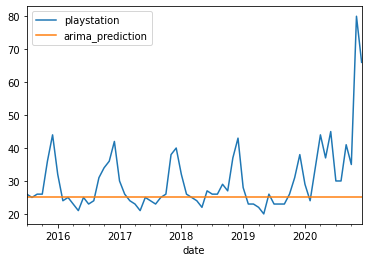

In [18]:
test[['playstation', 'arima_prediction']].plot()
plt.show()

As we can see, the basic ARIMA model is worse than our dummy model. It cannot handle seasonality, so it can't perform well in this kind of situation.

#### Rolling forecasts 7 month window

In [19]:
parameters = {'order': (4, 2, 2), 'with_intercept': False} # obtained with auto_arima previously

In [20]:
class ARIMAModel():
    
    def __init__(self):
        self.model = None
    
    def train(self, data: pd.Series, **kwargs):
        self.model = ARIMA(data, order=kwargs['order']).fit()
        
    def predict(self, duration: int) -> pd.Series:
        return self.model.forecast(steps=duration)
    
    @classmethod
    def rolling_forecast(cls, parameters: dict, train: pd.DataFrame, test: pd.DataFrame, window: int = 7) -> dict:
        history = train.copy()
        predictions = None
        for test_index in tqdm(range(0, len(test), window)):
            m = cls()
            m.train(data=history.playstation,
                    **parameters
                   ) 
            new_predictions = m.predict(window)
            if predictions is None:
                predictions = new_predictions
            else:
                predictions = pd.concat([predictions, new_predictions])
            history = history.append([test[test_index: test_index + window]])
        return predictions

In [21]:
rolling_predictions = ARIMAModel.rolling_forecast(parameters, train, test)

100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


In [22]:
test = test.assign(rolling_predictions=rolling_predictions)

In [23]:
mse = mean_squared_error(test.playstation, test.rolling_predictions)
mae = mean_absolute_error(test.playstation, test.rolling_predictions)
r2 = r2_score(test.playstation, test.rolling_predictions)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 137.73345503756155
	-> mae 9.076142027690668
	-> r2 -0.35871614661268825


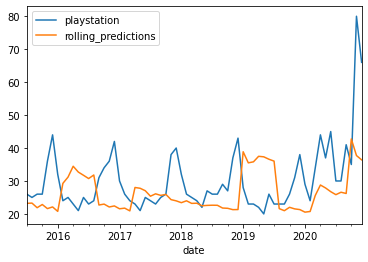

In [24]:
test[['playstation', 'rolling_predictions']].plot()
plt.show()

When using rolling forecasts, we can see that our performance is even worse than before with either the arima model that made a straight line, or with the dummy model.

#### Rolling forecast 1 month window

In [25]:
rolling_predictions = ARIMAModel.rolling_forecast(parameters, train, test, 1)

100%|██████████| 66/66 [00:14<00:00,  4.53it/s]


In [26]:
test = test.assign(rolling_predictions_1_month=rolling_predictions)

In [27]:
mse = mean_squared_error(test.playstation, test.rolling_predictions_1_month)
mae = mean_absolute_error(test.playstation, test.rolling_predictions_1_month)
r2 = r2_score(test.playstation, test.rolling_predictions_1_month)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 70.3024396836029
	-> mae 5.407347798025739
	-> r2 0.3064788803974594


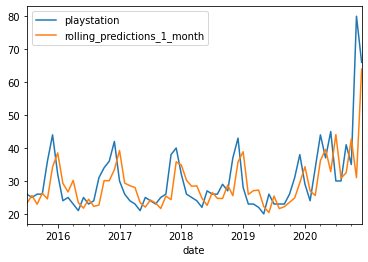

In [28]:
test[['playstation', 'rolling_predictions_1_month']].plot()
plt.show()

By using a 1 month window rolling forecast, we obtain better results than before. As we can see, it seems like all our forecasts suffer from the 1 month lag.

The results are better, but not so good yet.

### SARIMA Model

In [29]:
sarima_model = auto_arima(df.playstation, seasonal=True, m=12)

In [30]:
predictions = sarima_model.predict(len(test))

In [31]:
test = test.assign(sarimax_prediction=predictions)

In [32]:
mse = mean_squared_error(test.playstation, test.sarimax_prediction)
mae = mean_absolute_error(test.playstation, test.sarimax_prediction)
r2 = r2_score(test.playstation, test.sarimax_prediction)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 510.68252546235595
	-> mae 20.705163907963772
	-> r2 -4.0377926913212265


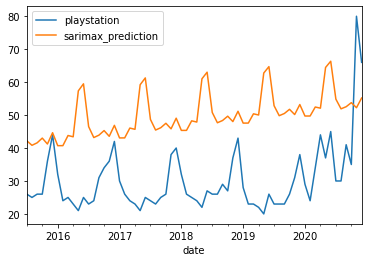

In [33]:
test[['playstation', 'sarimax_prediction']].plot()
plt.show()

As we can see above, the SARIMAX model with no rolling forecasts performs really badly.

In [54]:
class SARIMAXModel():
    
    def __init__(self):
        self.model = None
    
    def train(self, data: pd.Series, **kwargs):
        with StepwiseContext(max_dur=15):
            self.model = (
                auto_arima(
                    y=data,
                    seasonal=kwargs['seasonal'],
                    m=kwargs['m'],
                    stepwise=True
                )
            )
        
    def predict(self, duration: int, **kwargs) -> pd.Series:
        return pd.Series(self.model.predict(n_periods=duration))
    
    @classmethod
    def rolling_forecast(cls, parameters: dict, train: pd.DataFrame, test: pd.DataFrame,window: int) -> dict:
        predictions_folds = {}
        i = 0
        
        history = train.copy()
        predictions = None
        parameters = {'seasonal': True, 'm': window}
        for test_index in tqdm(range(0, len(test), window)):
            m = cls()
            m.train(data=history.playstation, **parameters) 
            new_predictions = m.predict(window)
            if predictions is None:
                predictions = new_predictions
            else:
                predictions = pd.concat([predictions, new_predictions])
            history = history.append([test[test_index: test_index + window]])
        return predictions

#### Rolling forecasts

In [55]:
rolling_predictions_sarimax = SARIMAXModel.rolling_forecast({}, train, test, 1)

100%|██████████| 66/66 [01:16<00:00,  1.16s/it]


In [60]:
test = test.assign(rolling_predictions_1_month=rolling_predictions_sarimax.values)

In [61]:
mse = mean_squared_error(test.playstation, test.rolling_predictions_1_month)
mae = mean_absolute_error(test.playstation, test.rolling_predictions_1_month)
r2 = r2_score(test.playstation, test.rolling_predictions_1_month)
print(f'\n\t-> mse {mse}\n\t-> mae {mae}\n\t-> r2 {r2}')


	-> mse 71.69282349029305
	-> mae 4.738820850731051
	-> r2 0.29276299032831443


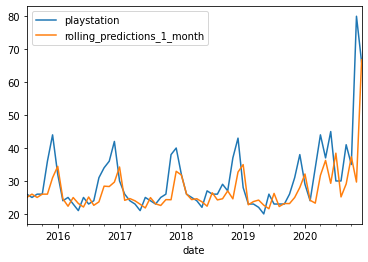

In [62]:
test[['playstation', 'rolling_predictions_1_month']].plot()
plt.show()

As we can see above, using SARIMAX model with a yearly seasonality increases our performances. 

There are not yet perfect, but increasing in the right way.